# Download Dataset

Download (10GB) the Military Aircraft Detection Dataset from Kaggle, unzip just the dataset into raw

Total RAW data = 8GB

**IMPORTANT**: Api key (json) from Kaggle needs to be added to the notebooks folder of the project in order to download the dataset

In [ ]:
# Check if in a Google Colab
COLAB = False

try:
    import google.colab
    COLAB = True
except ImportError:
    COLAB = False

if COLAB:
    !git clone https://github.com/marcgj/sky-defender.git
    %cd sky-defender/notebooks/



fatal: destination path 'sky-defender' already exists and is not an empty directory.
/content/sky-defender/notebooks


#### Install Kaggle

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!ls


download     SkyDefender.ipynb	     yolo_files
kaggle.json  sky-defender-OLD.ipynb  yolov5s-cls.pt


#### Download Dataset

In [ ]:

TRUE_CONDITIONS = ['y', 'yes']

# Download the dataset
download = input('\tYes(Y)/No(N): ')

if download.lower() in TRUE_CONDITIONS:
    ! mkdir download
    ! kaggle datasets download -d a2015003713/militaryaircraftdetectiondataset -p download
    # Unzip the dataset
    !mkdir -p ../data/raw
    !mkdir -p ../data/interim
    !unzip -j ./download/militaryaircraftdetectiondataset.zip "dataset/*" -d ../data/raw
    # Remove temporal files?
    !rm -rf ./download

	Yes(Y)/No(N): n


## Loading Dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
!pwd

/content/sky-defender/notebooks


In [ ]:
csv_path = "../data/raw/"
df = pd.concat([pd.read_csv(csv_path + f, delimiter=',') for f in os.listdir(csv_path) if f.endswith('.csv')], ignore_index=True)

In [ ]:
df.to_csv('../data/interim/merged_info.csv', index=False)

## Checking Null Values

In [ ]:
if df.isnull().values.any():
    print("There are null values in DF")
else:
    print("No null values in DF.")

No null values in DF.


## Examining classes

<Axes: ylabel='class'>

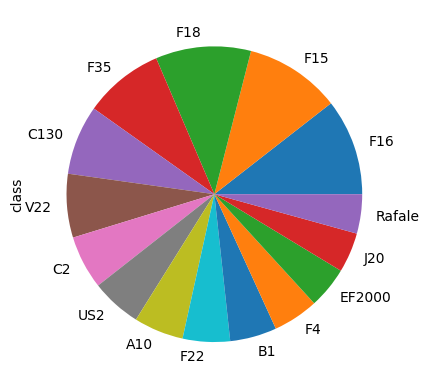

In [ ]:
df["class"].value_counts().head(15).plot(kind="pie") #See where can we reduce a bit our dataset

## Reducing classes
Because the dataset is very large and our project is focused more in object detection, we will be using just 3 classes in order to reduce computing time 

Reduced from 17968 rows to 3162 rows
F16    1060
F15    1053
F18    1049
Name: class, dtype: int64


<Axes: ylabel='class'>

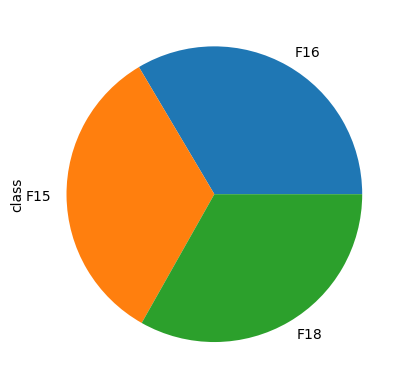

In [ ]:
target = ["F16", "F15", "F18"] #Classes we want to keep

df_reduced = df.loc[df["class"].isin(target)].copy(deep=True)

print(f"Reduced from {len(df.index)} rows to {len(df_reduced.index)} rows")
counts = df_reduced["class"].value_counts()
print(counts)
counts.plot(kind="pie")


# Loading images

## Adding paths to images

In [ ]:
# Image location
images_dir = '../data/raw/'

df_clean = df_reduced.copy(deep = True)

# Add the filepath to the image into the dataframe
df_clean['filepath'] = images_dir + df['filename'] + '.jpg'
df_clean.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,filepath
4,34ef95c3ecb2eaf50090cfdddf9ddf75,1920,1200,F18,232,219,1832,886,../data/raw/34ef95c3ecb2eaf50090cfdddf9ddf75.jpg
11,7f4348a14fbf33630ab0701d3687e141,1280,851,F15,310,161,1062,715,../data/raw/7f4348a14fbf33630ab0701d3687e141.jpg
15,3eab5b13cff1c38f1fa517b03d6f6960,1600,1066,F15,120,119,989,378,../data/raw/3eab5b13cff1c38f1fa517b03d6f6960.jpg
32,a797372671f5dcd3e7ff91889e1946cd,1080,608,F18,237,8,878,605,../data/raw/a797372671f5dcd3e7ff91889e1946cd.jpg
38,9aa3009e8bb0440d0e09058072db036e,4096,2726,F18,106,606,4017,1826,../data/raw/9aa3009e8bb0440d0e09058072db036e.jpg


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Normalize images and bounding boxes

In [ ]:
df_norm = df_reduced.copy(deep = True)
# Iteración sobre el dataframe
for index, row in df_clean.iterrows():
    width = row["width"]
    height = row["height"]
    
    # Calcular las coordenadas normalizadas
    x_min = row['xmin'] / width
    y_min = row['ymin'] / height
    x_max = row['xmax'] / width
    y_max = row['ymax'] / height
    
    # Obtener la etiqueta de clase
    label = row['class']
    
    x_center = (x_min + x_max)/2
    y_center = (y_min + y_max)/2
    
    width = x_max - x_min
    height = y_max - y_min
    
    # Guardar las coordenadas normalizadas y la etiqueta en el dataframe
    df_norm.at[index, 'x_center'] = x_center
    df_norm.at[index, 'y_center'] = y_center
    df_norm.at[index, 'width'] = width
    df_norm.at[index, 'height'] = height

### Remove columns YOLO does not use

In [ ]:
df_norm = df_norm.drop(["xmin", "ymin", "xmax", "ymax"], axis=1)
df_norm.head(1)

,filename,width,height,class,x_center,y_center
4,34ef95c3ecb2eaf50090cfdddf9ddf75,0.833333,0.555833,F18,0.5375,0.460417


### Change class to numeric value

In [ ]:
df_norm = df_norm.replace({"F15": 0, "F16": 1,"F18": 2})
df_norm.sample(5)

,filename,width,height,class,x_center,y_center
17639,f34850a95c83a93a75ebf0e3fded43c2,0.550000,0.419192,1,0.677941,0.450337
11357,5fbf1c97000553d77d58664b781c2729,0.131000,0.113943,2,0.341500,0.586207
11147,8f67b81f85e591db607bd99f2527752a,0.083611,0.064762,0,0.504028,0.584762
8916,694f82f5a9ac55294a61608345060c0c,0.029888,0.035866,1,0.136986,0.434347
328,7b7762b73dc625d81a4cf54ae2441624,0.322266,0.234375,2,0.339844,0.504340


## Train Test Split
In order to balance the classes between train/test we first group them by class and split each class into train and test

In [ ]:
#Create Train and Test sets
train_dfs = []
test_dfs = []

grouped = df_norm.groupby('class') 

for category, group_df in grouped:
    # Divide the sets
    train_df, test_df = train_test_split(group_df, test_size=0.2, random_state=42) #For each group, we set an 80% train 20%test
    train_dfs.append(train_df)
    test_dfs.append(test_df)
    
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)


In [ ]:
print("----------- TRAIN -------------")
print("Total: "+ str(len(train_df)))
print(train_df["class"].value_counts())
print("\n----------- TEST -------------")
print("Total: " + str(len(test_df)))
print(test_df["class"].value_counts())


----------- TRAIN -------------
Total: 2529
1    848
0    842
2    839
Name: class, dtype: int64

----------- TEST -------------
Total: 633
1    212
0    211
2    210
Name: class, dtype: int64


# Using YOLO
We will download the YOLOv5 repo in order to change the classes in its model to ours so it can classify them


## Downloading repo and installing dependencies


In [ ]:
!git clone https://github.com/ultralytics/yolov5 ../references/yolov5  # clone
%pip install -qr ../references/yolov5/requirements.txt  # install

fatal: destination path '../references/yolov5' already exists and is not an empty directory.


## Copying our .yml config file to yolov5 folder
The file contains the info necessary for the 5 classes we will be using

In [ ]:
!cp yolo_files/skydefender.yaml ../references/yolov5/data

### Creating folder structure for yolov5

In [ ]:
# yolov5
#   -images
#    |- train
#    |- val
#   -labels
#    |- train
#    |- val
!rm -fr ../data/processed/yolov5

!mkdir -p ../data/processed/yolov5
!mkdir -p ../data/processed/yolov5/images
!mkdir -p ../data/processed/yolov5/labels
!mkdir -p ../data/processed/yolov5/images/train
!mkdir -p ../data/processed/yolov5/images/val
!mkdir -p ../data/processed/yolov5/labels/train
!mkdir -p ../data/processed/yolov5/labels/val


### Copying images to its folder

In [ ]:
import shutil

grouped_train = train_df.groupby('filename')
grouped_test = test_df.groupby('filename')

def convert_yolo(group, folder):
    for i, (filename, df) in enumerate(group, 1):
        # Create file in labels
        with open(f"../data/processed/yolov5/labels/{folder}/{i}.txt", "w+") as f:
            for _, row in df.iterrows():
                line = str(
                    f"{row['class']} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n")
                f.write(line)
        # Move the image and change its name
        shutil.copy(f"../data/raw/{filename}.jpg",
                    f"../data/processed/yolov5/images/{folder}/{i}.jpg")
        
convert_yolo(grouped_train, "train")
convert_yolo(grouped_test, "val")


In [ ]:
%cd ../references/yolov5
import torch
import utils
display = utils.notebook_init()  # checks
%cd ../../notebooks

YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.9/78.2 GB disk)
/content/sky-defender/notebooks


# Training YOLOv5

In [ ]:

!python ../references/yolov5/train.py --weights yolov5s.pt --data skydefender.yaml --epochs 5 --img 640 --nosave --cache

train: weights=yolov5s.pt, cfg=, data=skydefender.yaml, hyp=../references/yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../references/yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_ga

## Evaluating with detect.py
We will try the model using the eval images

**Important:**
`--weights ../references/yolov5/runs/train/expX/weights/last.pt` might need the number in the X to be changed in order to use the weights from the last training

Also, `--coef` is set to 0.25 so we can see more boxes

In [ ]:
!python ../references/yolov5/detect.py --weights ../references/yolov5/runs/train/exp9/weights/last.pt --img 640 --conf 0.25 --source ../data/processed/yolov5/images/val/

['318.jpg', '458.jpg', '314.jpg', '230.jpg', '129.jpg', '15.jpg', '357.jpg', '347.jpg']


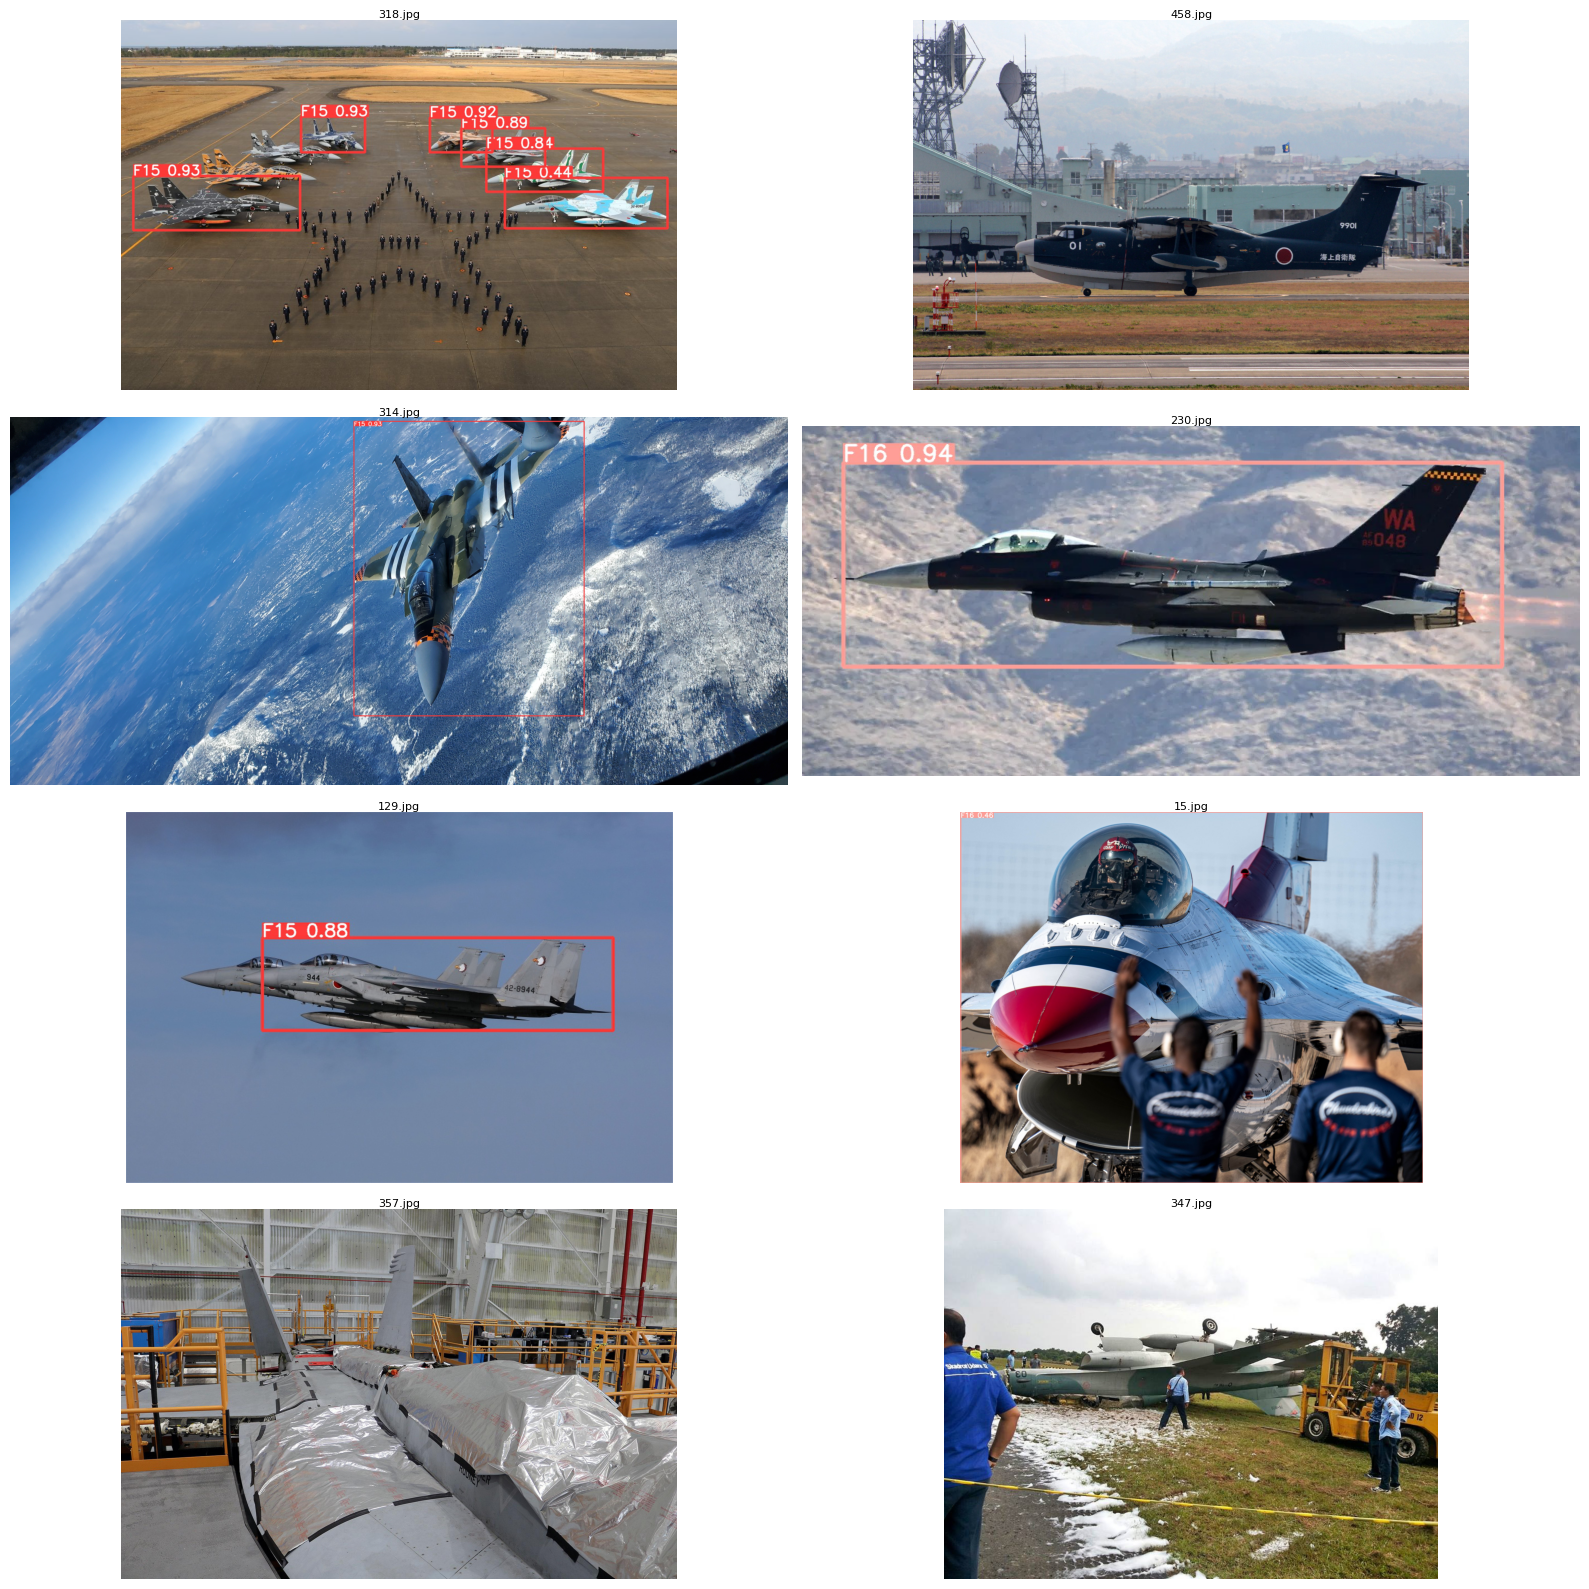

In [81]:
from random import sample 
import matplotlib.image as mpimg

lastest = max(os.listdir("../references/yolov5/runs/detect"))

images =  os.listdir(f"../references/yolov5/runs/detect/{lastest}/")
sample = sample(images, 8)

print(sample)

fig, axs = plt.subplots(4, 2, figsize=(16, 16))

for i, ax in enumerate(axs.flatten()):
    img = mpimg.imread(f"../references/yolov5/runs/detect/{lastest}/{sample[i]}")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(sample[i], fontsize=8, pad=2)


plt.tight_layout()
plt.show()